In [1]:
from imutils import contours
import numpy as np
import imutils
import cv2 
import matplotlib.pyplot as plt
import time
import pytesseract
import pyzbar.pyzbar as pyzbar
import re

def showfig(image, ucmap):
    #There is a difference in pixel ordering in OpenCV and Matplotlib.
    #OpenCV follows BGR order, while matplotlib follows RGB order.
    if len(image.shape)==3 :
        b,g,r = cv2.split(image)       # get b,g,r
        image = cv2.merge([r,g,b])     # switch it to rgb
    imgplot=plt.imshow(image, ucmap)

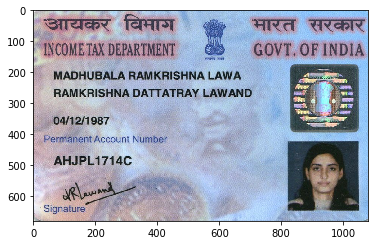

In [2]:
input_image = cv2.imread("pan2.jpg")

def resize_img(image):
    # here 1080 is the new width of the image
    # shape[1] is the old width of image 
    # r is the aspect ratio, to calculate the new height we are multiplying it with previous height
    # interpolation is the main algorithm running behind resizing the image
    r = 1080.0 / input_image.shape[1]
    dim = (1080, int(input_image.shape[0] * r))
    resized_image = cv2.resize(input_image, dim, interpolation = cv2.INTER_CUBIC)
    return resized_image

image=resize_img(input_image)
showfig(image, plt.get_cmap('gray'))

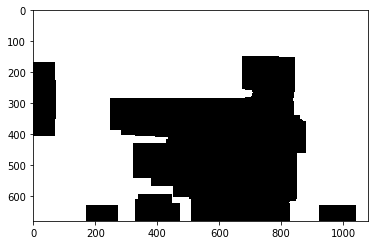

In [3]:
def pre_process(image):
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100,3))
  
    sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #gray = cv2.fastNlMeansDenoising(gray,None,10,7,21)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    tophat = cv2.morphologyEx(blur, cv2.MORPH_TOPHAT, rectKernel)

    gradX = np.absolute(cv2.Sobel(tophat, ddepth=cv2.CV_8U, dx=1, dy=0,ksize=-1))
    
    
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
    _, thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY| cv2.THRESH_OTSU )
    
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    
    return thresh

img=pre_process(image)

showfig(img, plt.get_cmap('gray'))

[[1079  678]
 [   0  678]
 [   0    0]
 [1079    0]]


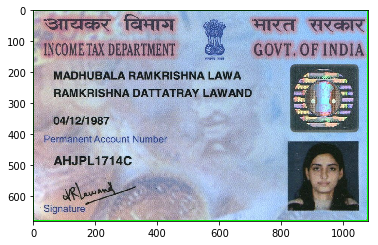

In [4]:
# find contours in the thresholded image
contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# loop over the contours to plot all the contours over cheque image

img_box=image.copy()
max_h=0
b=None

for cnt in contours:
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box)
    w=abs(box[0][0]-box[3][0])
    h=abs(box[0][1]-box[2][1])
    if (h>max_h):
        max_h=h
        b=box

print(b)
img=cv2.drawContours(img_box, [b], 0, (0,255,0),5)
    
showfig(img, None)


In [5]:
"""def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = (rect[0], rect[1], rect[2], rect[3])
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([[0, 0],[maxWidth , 0],[maxWidth , maxHeight ],[0, maxHeight ]], dtype = "float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth,maxHeight))
    
    return warped
"""

'def order_points(pts):\n    rect = np.zeros((4, 2), dtype = "float32")\n    \n    s = pts.sum(axis = 1)\n    rect[0] = pts[np.argmin(s)]\n    rect[2] = pts[np.argmax(s)]\n    \n    diff = np.diff(pts, axis = 1)\n    rect[1] = pts[np.argmin(diff)]\n    rect[3] = pts[np.argmax(diff)]\n    \n    return rect\n\ndef four_point_transform(image, pts):\n    rect = order_points(pts)\n    (tl, tr, br, bl) = (rect[0], rect[1], rect[2], rect[3])\n    \n    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))\n    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))\n    maxWidth = max(int(widthA), int(widthB))\n    \n    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))\n    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))\n    maxHeight = max(int(heightA), int(heightB))\n\n    dst = np.array([[0, 0],[maxWidth , 0],[maxWidth , maxHeight ],[0, maxHeight ]], dtype = "float32")\n    M = cv2.getPerspectiveTransform(rect, dst)\n    warped = 

In [6]:
"""img_r=four_point_transform(image, b)
showfig(img_r, None)
"""

'img_r=four_point_transform(image, b)\nshowfig(img_r, None)\n'

In [7]:
 #def detect(image):
    # convert the image to grayscale
 #   gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
    # compute the Scharr gradient magnitude representation of the images
    # in both the x and y direction
 #   gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
  #  gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
 # subtract the y-gradient from the x-gradient
  #  gradient = cv2.subtract(gradX, gradY)
  #  gradient = cv2.convertScaleAbs(gradient)
#
  #  blurred = cv2.blur(gradient, (9, 9))
   # (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    # construct a closing kernel and apply it to the thresholded image
   # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
  #  closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
 #   # perform a series of erosions and dilations
  #  closed = cv2.erode(closed, None, iterations = 4)
  #  closed = cv2.dilate(closed, None, iterations = 4)
    # find the contours in the thresholded image
  #  (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    # if no contours were found, return None
 #   if len(cnts) == 0:
  #      return None
    
    # otherwise, sort the contours by area and compute the rotated
    # bounding box of the largest contour
 """c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    rect = cv2.minAreaRect(c)
    box = np.int0(cv2.boxPoints(rect))
    box[0][0]=box[0][0]-10
    box[0][1]=box[0][1]+10
    box[1][0]=box[1][0]-10
    box[1][1]=box[1][1]-10
    
    box[2][0]=box[2][0]+10 
    box[2][1]=box[2][1]-10 
    box[3][0]=box[3][0]+10 
    box[3][1]=box[3][1]+10 
    
    # return the bounding box of the barcode
    return box

img = cv2.imread('bar_v40.png')
start = time.clock()
box = detect(img_r)
print(box)

qr_img = img_r.copy()
# if a barcode was found, draw a bounding box on the frame
# cv2.drawContours(qr_img, [box], -1, (0, 255, 0), 5)

img_qr=four_point_transform(qr_img, box)

# image1=ocr_preprocess(img_qr)
# image2 = ocr_preprocessBar(img_qr)
barcodes = pyzbar.decode(img_qr)
#print(barcodes)

for barcode in barcodes:
    
    (x, y, w, h) = barcode.rect
    barcodeData = barcode.data.decode("utf-8")
    barcodeType = barcode.type
    text = "{} ({})".format(barcodeData, barcodeType)
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 0, 255), 2)    
end = time.clock()
print(end-start)''''''
#showfig(image2, plt.get_cmap('gray'))
print((barcodeData).split(':'))



"""

'c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]\n   rect = cv2.minAreaRect(c)\n   box = np.int0(cv2.boxPoints(rect))\n   box[0][0]=box[0][0]-10\n   box[0][1]=box[0][1]+10\n   box[1][0]=box[1][0]-10\n   box[1][1]=box[1][1]-10\n   \n   box[2][0]=box[2][0]+10 \n   box[2][1]=box[2][1]-10 \n   box[3][0]=box[3][0]+10 \n   box[3][1]=box[3][1]+10 \n   \n   # return the bounding box of the barcode\n   return box\n\nimg = cv2.imread(\'bar_v40.png\')\nstart = time.clock()\nbox = detect(img_r)\nprint(box)\n\nqr_img = img_r.copy()\n# if a barcode was found, draw a bounding box on the frame\n# cv2.drawContours(qr_img, [box], -1, (0, 255, 0), 5)\n\nimg_qr=four_point_transform(qr_img, box)\n\n# image1=ocr_preprocess(img_qr)\n# image2 = ocr_preprocessBar(img_qr)\nbarcodes = pyzbar.decode(img_qr)\n#print(barcodes)\n\nfor barcode in barcodes:\n   \n   (x, y, w, h) = barcode.rect\n   barcodeData = barcode.data.decode("utf-8")\n   barcodeType = barcode.type\n   text = "{} ({})".format(barcodeDa

In [8]:
#def ocr_preprocessBar(image):
#    gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#    denoised = cv2.threshold(gray, 140, 255,cv2.THRESH_BINARY)[1]
#    #denoised = cv2.adaptiveThreshold(denoised,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,21,3)
 #   return denoised
#
#img=ocr_preprocessBar(img_qr)
#showfig(img, plt.get_cmap('gray'))

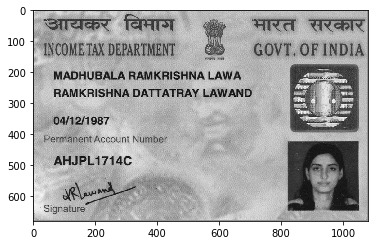

In [9]:
def ocr_preprocess(image):
    gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #denoised = cv2.fastNlMeansDenoising(gray,None,15,7,21)
    #denoised = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU )[1]
    #denoised = cv2.adaptiveThreshold(denoised,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,21,3)
    return gray

image_ocr=ocr_preprocess(img)
showfig(image_ocr, plt.get_cmap('gray'))

In [27]:
print(pytesseract.image_to_string(image_ocr))
out = pytesseract.image_to_string(image_ocr)
#cv2.imwrite('pan_img.jpg', image_ocr)

ART URL
GOVT. OF INDIA

Sieteee faa
INCOME TAX DEPARTMENT

MADHUBALA RAMKRISHNA LAWA
RAMKRISHNA DATTATRAY LAWAND

     

CED

Rat

04/12/1987

Permanent Account Number

AHJPL1714C

Qed —

Signature


In [28]:
out = out.replace("  ","")
out= out.split("\n")
print(out)
while '' in out:
    out.remove('')


['ART URL', 'GOVT. OF INDIA', '', 'Sieteee faa', 'INCOME TAX DEPARTMENT', '', 'MADHUBALA RAMKRISHNA LAWA', 'RAMKRISHNA DATTATRAY LAWAND', '', ' ', '', 'CED', '', 'Rat', '', '04/12/1987', '', 'Permanent Account Number', '', 'AHJPL1714C', '', 'Qed —', '', 'Signature']


In [29]:
out



['ART URL',
 'GOVT. OF INDIA',
 'Sieteee faa',
 'INCOME TAX DEPARTMENT',
 'MADHUBALA RAMKRISHNA LAWA',
 'RAMKRISHNA DATTATRAY LAWAND',
 ' ',
 'CED',
 'Rat',
 '04/12/1987',
 'Permanent Account Number',
 'AHJPL1714C',
 'Qed —',
 'Signature']

In [31]:
for item in out:
    if len(item)<=3:
        print("length of item is :" )
        print(out.remove(item))

    
print(out)       

length of item is :
None
['ART URL', 'GOVT. OF INDIA', 'Sieteee faa', 'INCOME TAX DEPARTMENT', 'MADHUBALA RAMKRISHNA LAWA', 'RAMKRISHNA DATTATRAY LAWAND', '04/12/1987', 'Permanent Account Number', 'AHJPL1714C', 'Qed —', 'Signature']


AttributeError: 'list' object has no attribute 'split'

In [32]:
)
        

TypeError: expected string or bytes-like object